In [47]:
import numpy as np
import pandas as pd
import os
import rasterio
from rasterio.windows import Window
import cv2
import tqdm
import random
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
config = {
    'resize': (512,512), #(1024,1024)
    'DATA': '/kaggle/input/hubmap-organ-segmentation/train_images',
    'MASKS' : '/kaggle/input/hubmap-organ-segmentation/train.csv',
    'Window' : (0,3000), #(250,2670)
}

In [3]:
#Helper functions
#convert encoding rle to mask
def enc2mask(encs, shape):
    '''
    Args:
    encs: list of rle masks
    shape: mask shape
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float32) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

In [4]:
df_masks = pd.read_csv(config['MASKS'])[['id', 'rle','organ']].set_index('id')
# df_masks.head()
# df_masks.loc[df_masks["organ"] == "kidney"].head(80)
# df_masks.loc[df_masks["organ"] == "kidney"].tail(19)

# kidney 99=80:19
# prostate 93=75:18
# large intestine 58=47:11
# spleen 53=43:10
# lung 48=39:9
# total 351=284:67=4:1
kidney = df_masks.loc[df_masks["organ"] == "kidney"].index.values.tolist()
prostate = df_masks.loc[df_masks["organ"] == "prostate"].index.values.tolist()
largeintestine = df_masks.loc[df_masks["organ"] == "largeintestine"].index.values.tolist()
spleen = df_masks.loc[df_masks["organ"] == "spleen"].index.values.tolist()
lung = df_masks.loc[df_masks["organ"] == "lung"].index.values.tolist()

# len(kidney) #99
# kidney[:80]
# kidney[-19:]
# len(kidney[:80] + kidney[-19:]) #99

train = kidney[:80] + prostate[:75] + largeintestine[:47] + spleen[:43] + lung[:39]
valid = kidney[-19:] + prostate[-18:] + largeintestine[-11:] + spleen[-10:] + lung[-9:]
len(train+valid)

351

In [44]:
#resize & cutoff each image mask pair with consistent dim
class HPAData():
    def __init__(self, idx, resize=config['resize'], slide=config['Window'], encs=None):
        self.data = rasterio.open(os.path.join(config['DATA'],str(idx)+'.tiff'), num_threads='all_cpus')
#         print(self.data)
        
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
                    
        self.shape = self.data.shape
        self.slide = slide
        self.resize = resize
        self.idx = idx
        
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        # read img (RGB), mask (grayscale) from window slide
        # img, mask: uint8
        img = self.data.read([1,2,3],window=Window.from_slices(self.slide,self.slide)) 
        mask = self.mask[self.slide[0]:self.slide[1], self.slide[0]:self.slide[1]] 
        
        # resize
        img = cv2.resize(np.transpose(img,(1,2,0)),(self.resize[0],self.resize[1]),
                         interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask,(self.resize[0], self.resize[1]),
                          interpolation = cv2.INTER_NEAREST)
        
        return img, mask, self.idx

In [50]:
#process train & validation sets
class HPADataset(Dataset):
    def __init__(self, category): #transform=None, target_transform=None
        self.total = 0
        self.img = []
        self.mask = []
        
        if category == "train":
            tempid = train
        elif category == "validation":
            tempid = valid
        else:
            print("Not matching either train/validation")
        
#         for index, row in df_masks.iterrows():
        for index in tempid:
            row = df_masks.loc[index]
            #rle: df_masks.loc[index][0], organ: df_masks.loc[index][1]
            print("{}: categorize image & mask {} with organ type {}".format(self.total, index, df_masks.loc[index][1])) 
            dp = HPAData(index,encs=row)
            img, m, idx = dp[0]

            #write data   
            # Convert BGR image to RGB image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             print(img)

            # Define a transform to convert the image to torch tensor
            transform = transforms.Compose([
                transforms.ToTensor()
            ])

            # Convert the image to Torch tensor
            tensorImg = transform(img) #F.pil_to_tensor(img)
#             print(tensorImg.shape)
#             print(tensorImg)

#https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
#ToTensor() should not be used when transforming target image masks...
            tensorMask = torch.as_tensor(np.array(m), dtype=torch.int64) #transform(m)
#             print(tensorMask.shape)
#             print(sum(tensorMask))

            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(m), alpha=0.2)
            self.img.append(tensorImg)
            self.mask.append(tensorMask)
            self.total+=1
            
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image = self.img[idx]
        mask = self.mask[idx]
        
        return image, mask
        

0: categorize image & mask 10611 with organ type kidney
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 11, 16, 24, 28, 32, 36, 38, 39, 41, 43, 46, 49,
        50, 53, 57, 59, 61, 63, 65, 66, 66, 67, 67, 66, 65, 64, 62, 61, 60, 59,
        58, 57, 56, 55, 54, 53, 52, 52, 51, 50, 49, 48, 46, 44, 42, 41, 39, 36,
        33, 31, 25, 20, 13,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 13, 20, 27, 30, 33, 36, 38, 41, 43, 45,
        47, 49, 50, 50, 52, 52, 53, 54, 54, 55, 56, 56, 57, 56, 56, 56, 56, 56,
        57, 57, 57, 57, 57, 56, 56, 55, 55, 53, 52, 51, 49, 47, 45, 42, 36,  8,
         0,  0,  0,  0,  0,  0,  0,  0,  4,  8, 11, 14, 15, 16, 16, 17, 18, 20,
        21, 31, 33, 34, 34, 35, 36, 35, 31, 31, 29, 26, 23, 21, 20, 19, 18, 16,
        15, 13, 11,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

KeyboardInterrupt: 

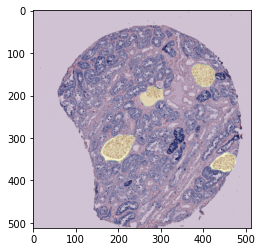

In [51]:
trainset = HPADataset("train")
validset = HPADataset("validation")
#0-283 + 0-66 = 284+67=351

In [ ]:
# load data using DataLoader
train_loader = DataLoader(trainset, batch_size=4, shuffle=True) #batch_size=3
valid_loader = DataLoader(validset, batch_size=4, shuffle=True)

for i, (images, masks) in enumerate(train_loader):
    print(images.shape)